In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import datetime
import os

In [2]:
df = pd.read_csv('./data/Crop_recommendation.csv')
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [3]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

In [4]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
num_classes = len(np.unique(labels))

# Convert the features and labels to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Normalize the features to have zero mean and unit variance
mean = features.mean(dim=0)
std = features.std(dim=0)
features = (features - mean) / std

In [5]:
with open("./model/pkl_files/encoder.pkl", "wb") as file:
    pickle.dump(encoder, file)

In [6]:
# Define a custom PyTorch dataset to wrap the features and labels
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [7]:
dataset = CustomDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [8]:
class Net_64_128_64(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Net_64_128_64, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x)


In [9]:
# Define the network hyperparameters
input_size = 7
num_classes = 22

# Initialize the network
net = Net_64_128_64(input_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Train the network
train_losses = []
val_losses = []


In [19]:
for epoch in range(100):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataset):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataset:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)
    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}/100: train loss: {train_loss:.4f} val loss: {val_loss:.4f}')

print('Finished training')


/tmp/ipykernel_1490811/925164282.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10/100: train loss: 2.2095 val loss: 2.2557
Epoch 20/100: train loss: 2.2072 val loss: 2.2545
Epoch 30/100: train loss: 2.2057 val loss: 2.2543
Epoch 40/100: train loss: 2.2047 val loss: 2.2550


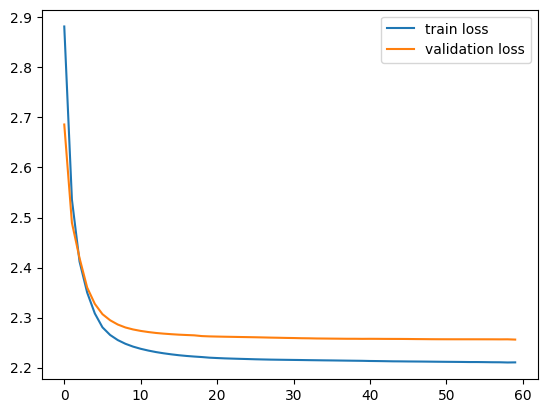

In [11]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

In [12]:
model_name = str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-') + '.hdf5'
file_name = f'./model/{model_name}'
if not os.path.exists('./model/'):
    os.mkdir('./model/')
    print("creating model dir")

In [13]:
torch.save(net.state_dict(), file_name)

In [17]:
model = Net_64_128_64(input_size,num_classes)
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

In [18]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_dataset:
        outputs = net(inputs)
        predicted = outputs.argmax() 
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        # print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the train: {accuracy:.2f}%')


/tmp/ipykernel_1490811/925164282.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Accuracy of the network on the train: 95.74%
